## **EP20BTECH11007**
## **Assignment 6**
### **Gowri Govindaraj**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import ndimage
from matplotlib.patches import Ellipse
import emcee
import corner
import scipy.optimize as op
from astroML.plotting import plot_mcmc
import seaborn
seaborn.set()

In [2]:
arXiv = [[1, 201, 592, 61 ],[2, 244, 401, 25 ],[3, 47, 583, 38 ],[4, 287, 402, 15 ],
        [5, 203, 495, 21 ],[6, 58, 173, 15 ],[7, 210, 479, 27 ],[8, 202, 504, 14 ],
        [9, 198, 510, 30 ],[10, 158, 416, 16 ],[11, 165, 393, 14 ],[12, 201, 442, 25 ],
        [13, 157, 317, 52 ],[14, 131, 311, 16 ],[15, 166, 400, 34 ],[16, 160, 337, 31 ],
        [17, 186, 423, 42 ],[18, 125, 334, 26 ],[19, 218, 533, 16 ],[20, 146, 344, 22 ]]
arXiv = np.array(arXiv)

### Q1

In 1919, two expeditions sailed from Britain to test if the light deflection from stars agrees with Einstein’s General Theory of Relativity. Einstein’s theory predicts a value of 1.74 arc-seconds, whereas Newtonian gravity predicts a value exactly half of that. The team by Eddington obtained a value of 1.61 ± 0.40 arc-seconds, while the team by Crommelin reported a
value of 1.98 ± 0.16 arc-seconds. Calculate the Bayes factor between General Relativity and Newtonian gravity from those data, assuming Gaussian likelihoods.

(For more information about these expeditions and associated controver-
sies, check out arXiv:0709.0685)

In [3]:
einstein_value = 1.74
newton_value = einstein_value/2.0
eddington_value = 1.61
eddington_error = 0.4
crommelin_value = 1.98
crommelin_error = 0.16

pdf_einstein_eddington = stats.norm.pdf(eddington_value, einstein_value, eddington_error)
pdf_einstein_crommelin = stats.norm.pdf(crommelin_value, einstein_value, crommelin_error)
pdf_newton_eddington = stats.norm.pdf(eddington_value, newton_value, eddington_error)
pdf_newton_crommelin = stats.norm.pdf(crommelin_value, newton_value, crommelin_error)

bayes_factor = (pdf_newton_crommelin*pdf_newton_eddington/
                (pdf_einstein_crommelin*pdf_einstein_eddington))

print("The Bayes factor between General Relativity and Newtonian gravity:" , bayes_factor)


The Bayes factor between General Relativity and Newtonian gravity: 2.0762126610332088e-11


### Q2

For exercise 1 in arXiv:1008.4686, calculate the 68% and 95% joint confi-
dence intervals on b and m.

In [4]:
x = arXiv[:,1][4:]
y = arXiv[:,2][4:]
sigma_y = arXiv[:,3][4:]

In [5]:
def log_prior(param):
    a,b,c = param
    if c < 0.0:
        return -np.inf
    return -1.5*np.log((1+ b**2)/c)

def log_likelihood(param, x, y, sigma_y):
    a,b,c = param
    model = a + b*x
    return -0.5*np.sum(((y-model)**2/c**2) + np.log(2 * np.pi * c**2))

def log_posterior(param, x, y, sigma_y):
    return log_likelihood(param, x, y, sigma_y) + log_prior(param)


In [6]:
n_dim = 3
n_walkers = 50
n_burn = 1000
n_steps = 2000

pos = np.random.normal(0,1,(n_walkers, n_dim))
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(x,y,sigma_y))
sampler.run_mcmc(pos, n_steps)
emcee_trace = sampler.chain[:, n_burn:, :].reshape((-1, n_dim)).T

/Users/gowrigovindaraj/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


/Users/gowrigovindaraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


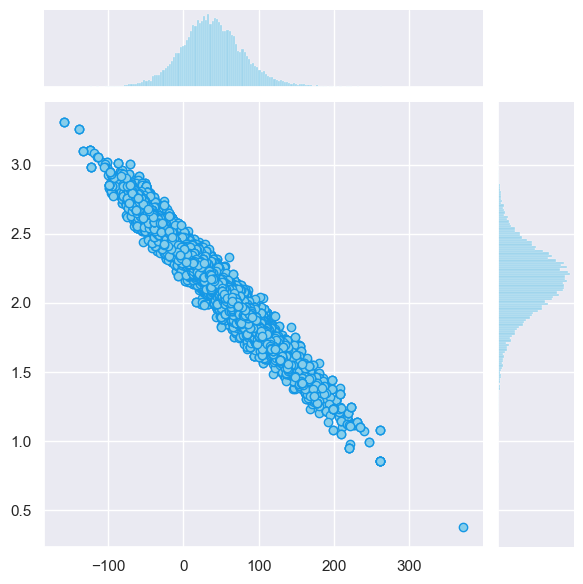

In [20]:
import seaborn as sns
sns.jointplot(emcee_trace.T[:,0] , emcee_trace.T[:,1], kind = "scatter", color='skyblue', edgecolor="#1497E5", linewidth=1)


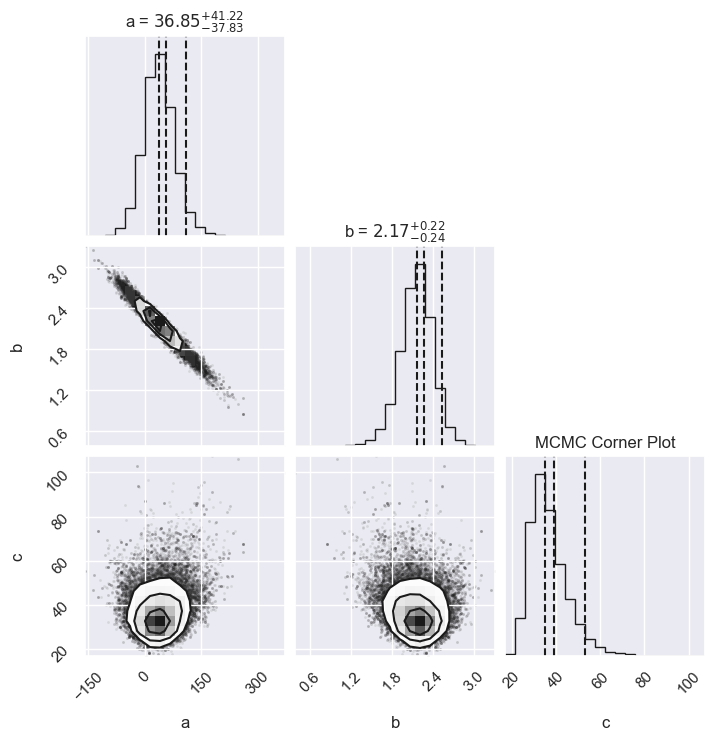

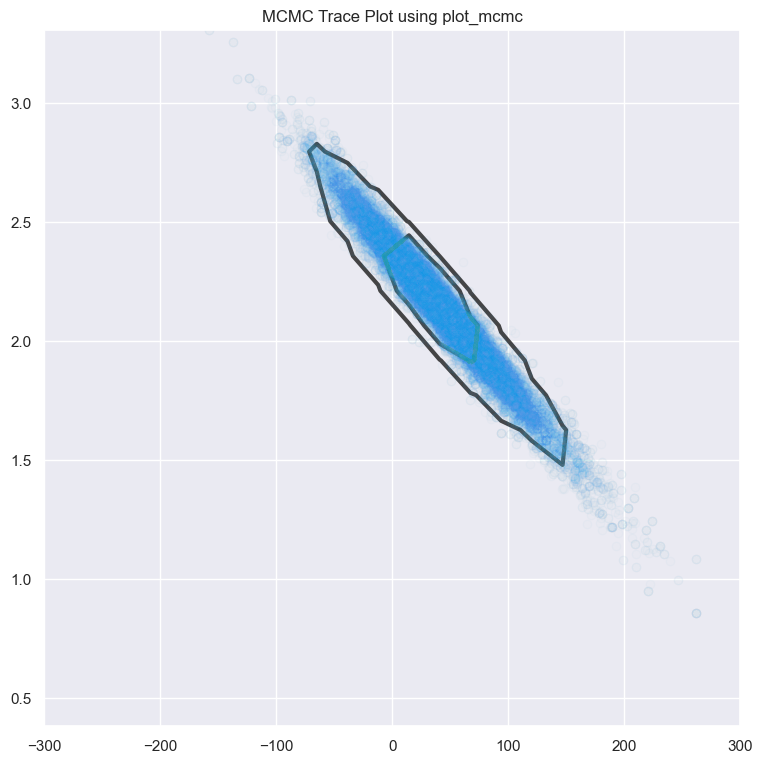

In [39]:
corner.corner(emcee_trace.T, labels=["a", "b", "c"], quantiles=[0.5,0.68, 0.95], show_titles=True, title_kwargs={"fontsize": 12})
plt.title("MCMC Corner Plot")
plt.show()

fig = plot_mcmc(emcee_trace[:2 , :] , colors = 'k' , linewidths = [3,3] , alpha = 0.80)
plt.plot(emcee_trace.T[:,0] , emcee_trace.T[:,1] , 'o' , alpha = 0.02, markeredgecolor = '#1497E5',markerfacecolor = 'skyblue')
plt.xlim(-300 , 300)
plt.title("MCMC Trace Plot using plot_mcmc")
plt.show()


## Q3

Fit the data in Table 1 of arXiv:1008.4686 to a straight line, after including all the data points, (after ignoring σx and ρxy) using both maximum likelihood analysis and using a Bayesian analysis to identify the outliers, using the same procedure as in the second of Jake VanDerPlas blog article. Show graphically the best fit line using both maximum likelihood analysis
and also using Bayesian analysis, including the outlier points.

In [24]:
x = arXiv[:,1]
y = arXiv[:,2]
sigma_y = arXiv[:,3]

def mean_squared_error(theta, x, y, sigma_y):
    a,b = theta
    y_model = a + b*x
    return np.sum(0.5* (y - y_model) ** 2 / ( sigma_y ** 2))

theta_1 = op.fmin(mean_squared_error, [0,0], args=(x,y,sigma_y), disp = False)


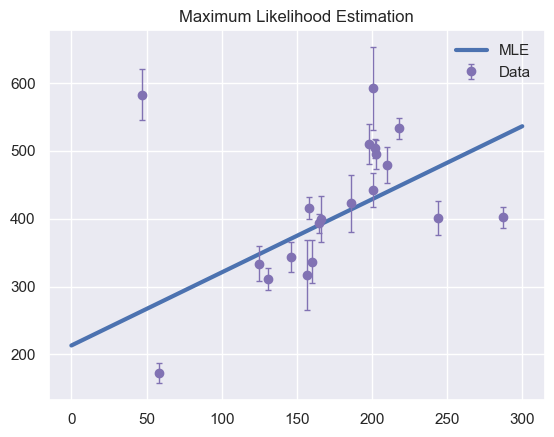

In [36]:
x_val = np.linspace(0, 300, 1000)
y_val = theta_1[0] + theta_1[1]*x_val

plt.plot(x_val, y_val, linewidth=3)
plt.errorbar(x, y, yerr=sigma_y, fmt='o', elinewidth=1, capsize=2, color='m', ecolor='m')
plt.title("Maximum Likelihood Estimation")
plt.legend(["MLE", "Data"])
plt.show()


In [28]:
def log_prior(param):
    if 1 > all(param[2:]) > 0:
        return 0
    return -np.inf


def log_likelihood(theta, x, y, sigma_y, sigma_b):
    model = theta[0] + theta[1] * x
    flag = np.clip(theta[2:],0,1) 
    log_like_1 = np.log(flag) - 0.5*np.log(2*np.pi*(sigma_y ** 2)) 
    log_like_1=log_like_1- 0.5 * ((y - model) / sigma_y)** 2
    log_like_2 = np.log(1 - flag) - 0.5*np.log(2*np.pi*(sigma_b**2)) 
    log_like_2+=- 0.5 * (((y-model)/sigma_b)**2)
    log_likelihd =  np.sum(np.logaddexp(log_like_1, log_like_2))
    return log_likelihd

def log_posterior(theta, x, y, sigma_y, sigma_b):
    return log_likelihood(theta, x, y, sigma_y, sigma_b) + log_prior(theta)

In [41]:
n_walkers = 50
n_steps = 25000 
n_burn = 15000
ndim = 2+len(x)

theta_start = np.random.normal(theta_1 , 1 , (n_walkers , 2))
g_start = np.random.normal(0.5,0.1 ,(n_walkers,len(x)))
pos = np.hstack((theta_start ,g_start))

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_fn=log_posterior, args=(x,y,sigma_y,50))
samples = sampler.run_mcmc(pos, n_steps)
emcee_trace = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))[: , :2]

theta_bayesian = np.mean(emcee_trace, axis=0)
g = np.mean(emcee_trace, axis=0)

/var/folders/27/qhs4lxjn7nq086n9lt_d64k80000gn/T/ipykernel_30123/526116856.py:12: RuntimeWarning: divide by zero encountered in log
  log_like_2 = np.log(1 - flag) - 0.5*np.log(2*np.pi*(sigma_b**2))
/Users/gowrigovindaraj/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/27/qhs4lxjn7nq086n9lt_d64k80000gn/T/ipykernel_30123/526116856.py:10: RuntimeWarning: divide by zero encountered in log
  log_like_1 = np.log(flag) - 0.5*np.log(2*np.pi*(sigma_y ** 2))


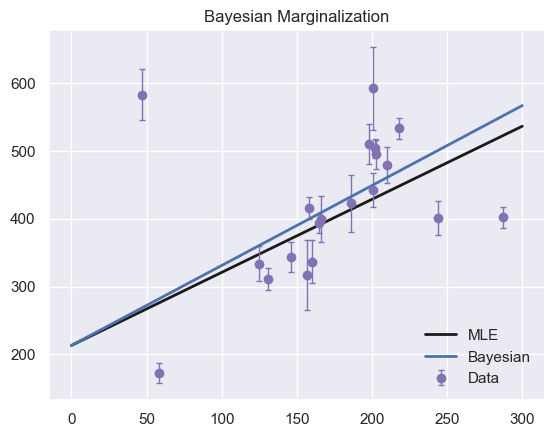

In [42]:
x_val = np.linspace(0, 300, 1000)
plt.plot(x_val , theta_1[0] + theta_1[1] * x_val , label = "MLE" , linewidth = 2, color = 'k')
plt.errorbar(x , y , yerr = sigma_y, fmt = 'o' , elinewidth = 1 , capsize = 2 , color = 'm' , ecolor = 'm')
plt.plot(x_val , theta_bayesian[0] + theta_bayesian[1] * x_val ,label = "Bayesian",linewidth = 2)
plt.title("Bayesian Marginalization")
plt.legend(["MLE", "Bayesian", "Data"])
plt.show()